In [1]:
# !pip install opencv-python scikit-learn pandas numpy matplotlib tensorflow-addons
# !pip install tensorflow==2.12 keras==2.12
# !pip install transformers datasets torchvision

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Missing keys: ['cls_classifier.weight', 'cls_classifier.bias', 'distillation_classifier.weight', 'distillation_classifier.bias']
Unexpected keys: []
Weights loaded. Device: cuda
--------------------------------------------------
Processing Category: Benign
--------------------------------------------------

Analyzing image: 1-007.dcm.png


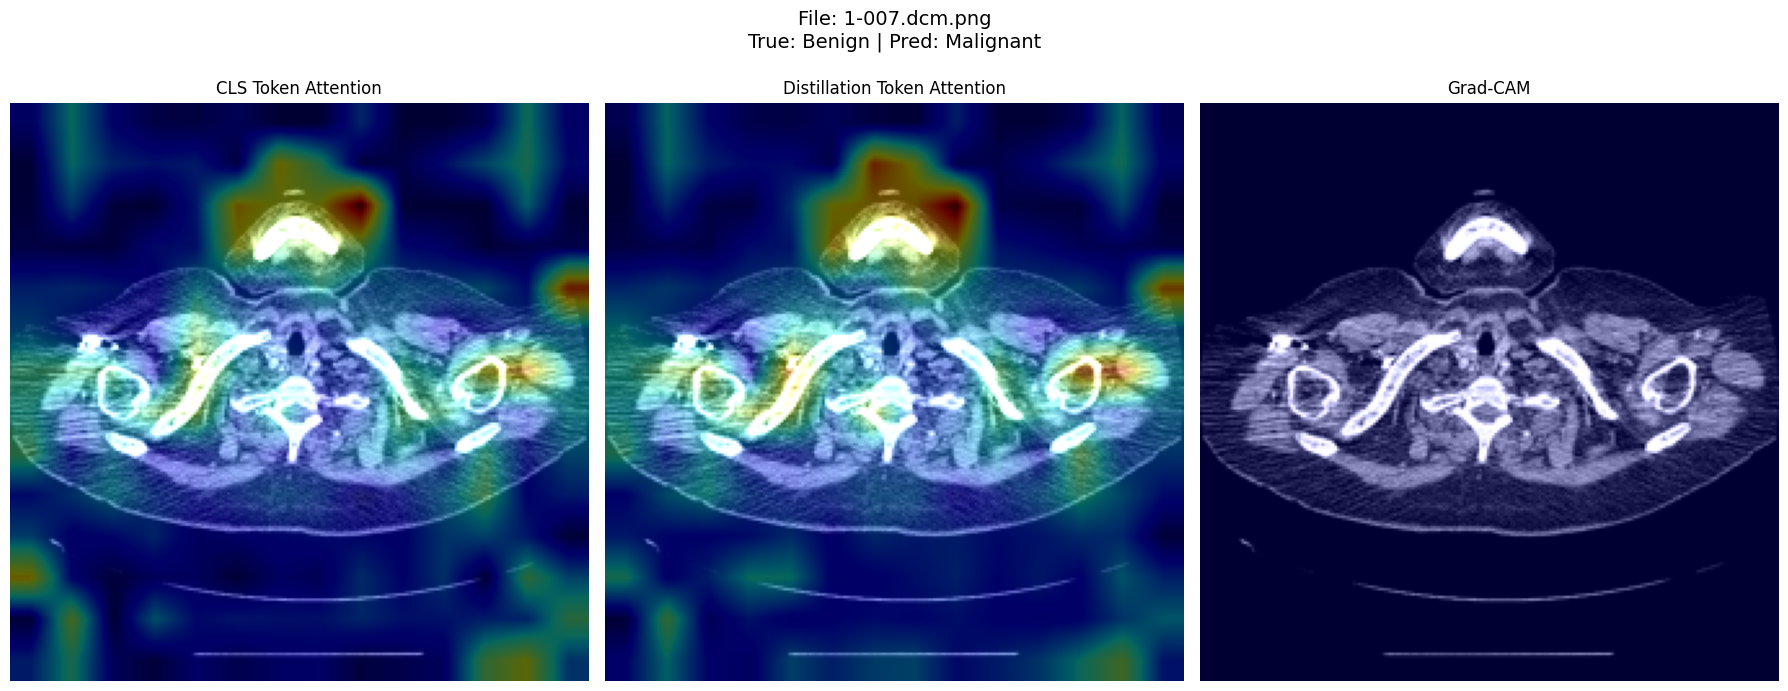


Analyzing image: 1-008.dcm.png


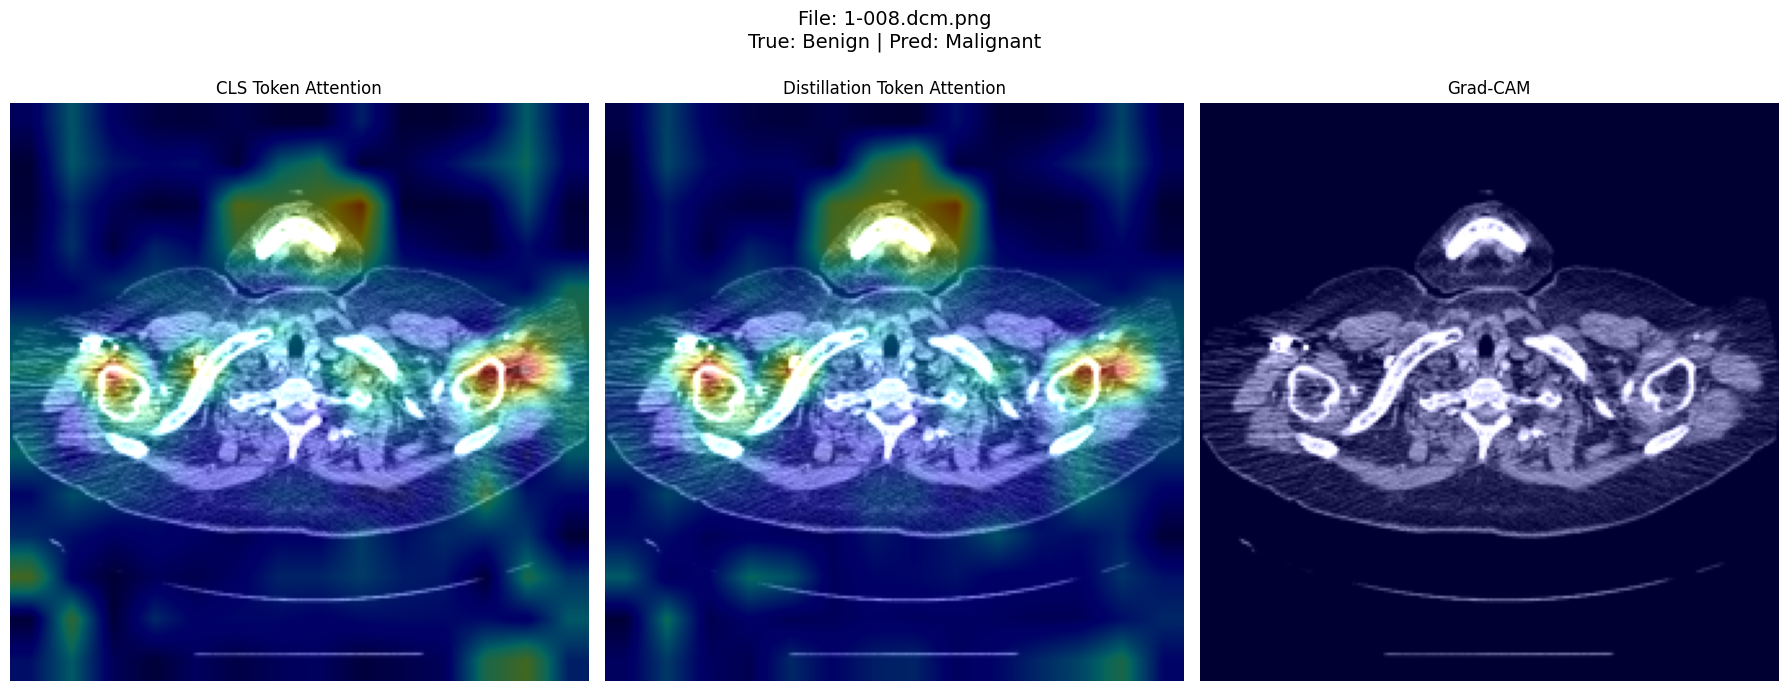


Analyzing image: 1-009.dcm.png


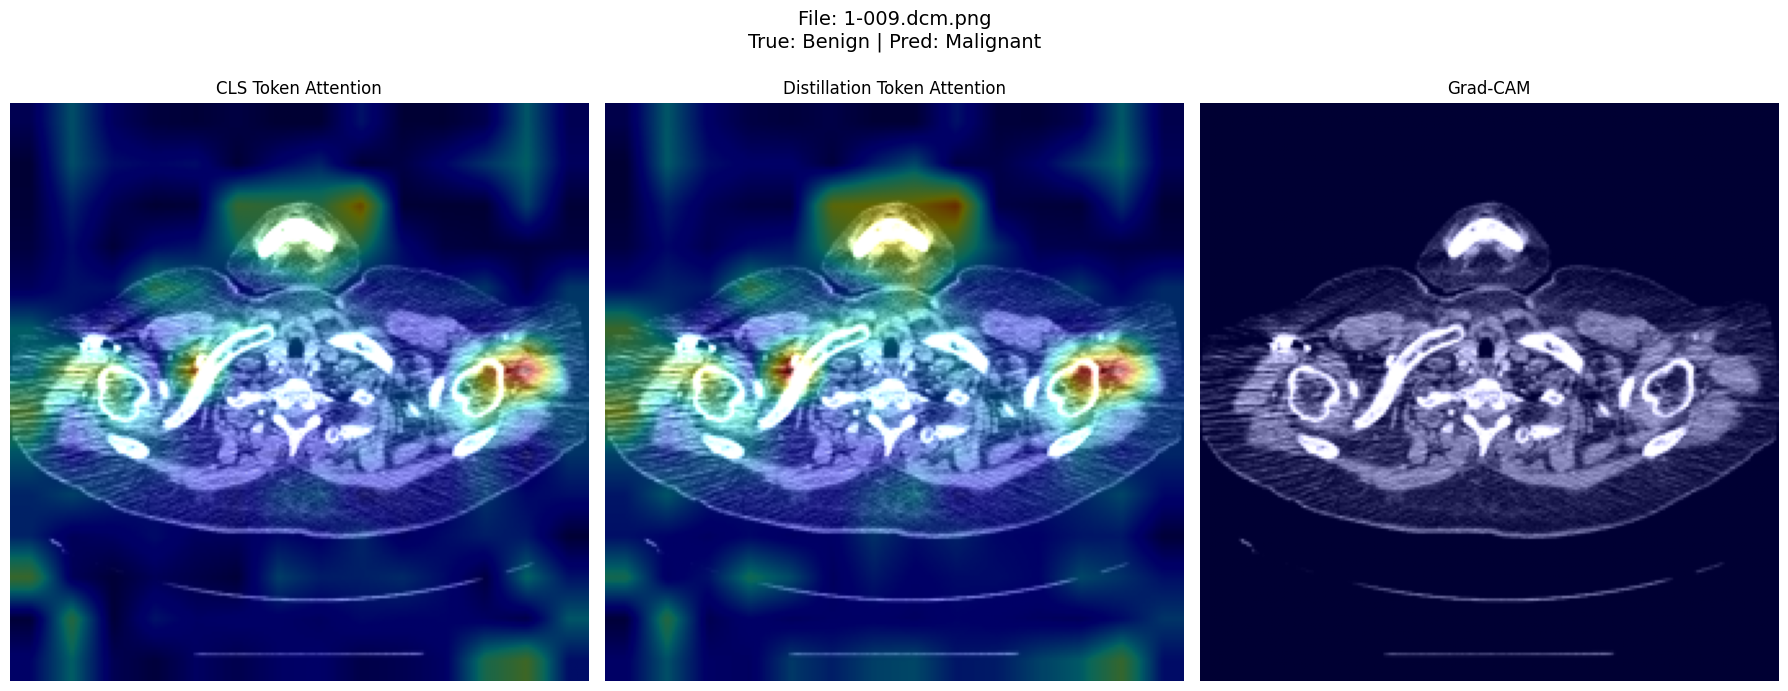

--------------------------------------------------
Processing Category: Malignant
--------------------------------------------------

Analyzing image: 1-007.dcm.png


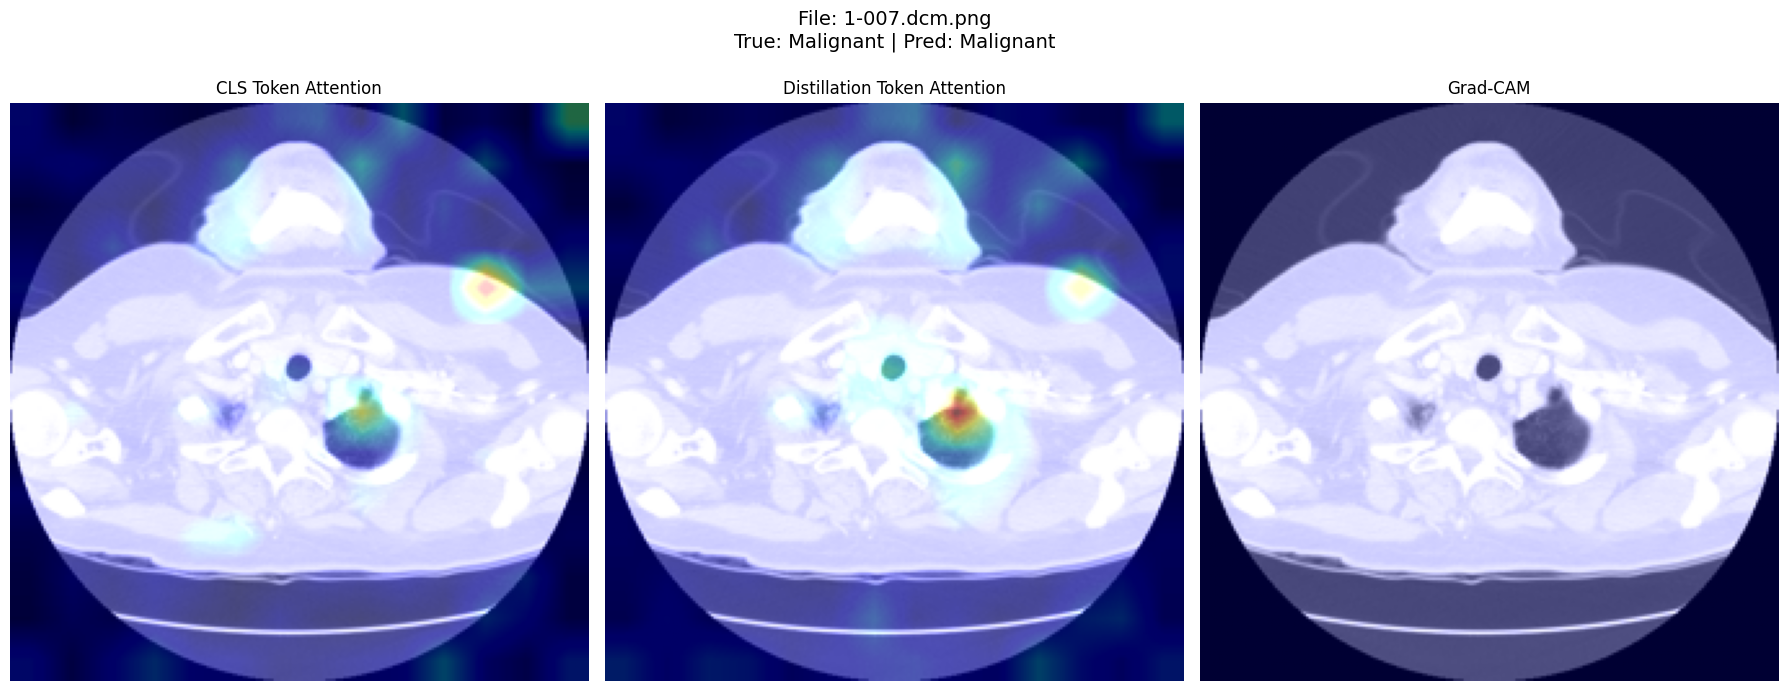


Analyzing image: 1-008.dcm.png


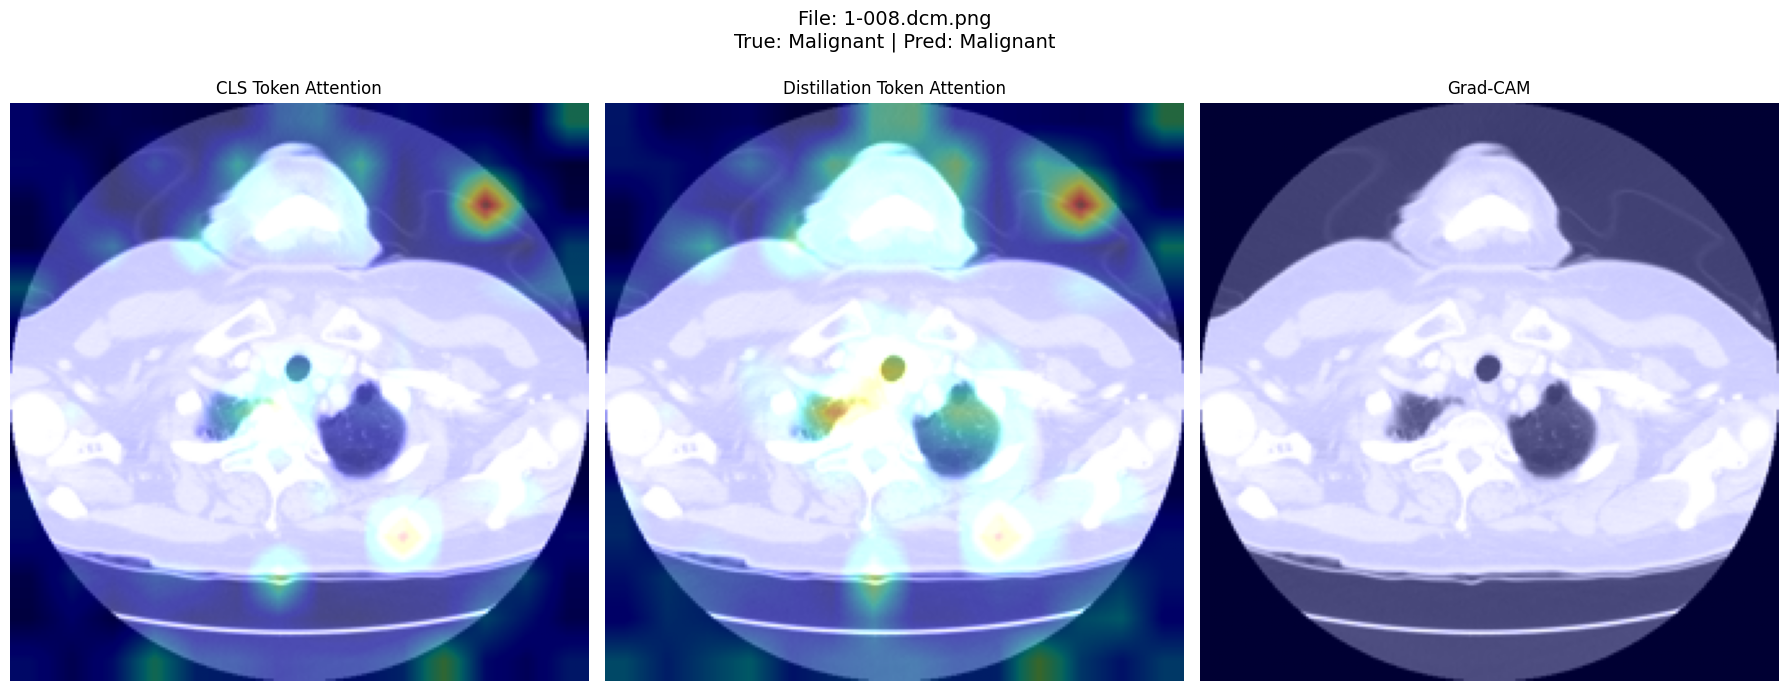


Analyzing image: 1-009.dcm.png


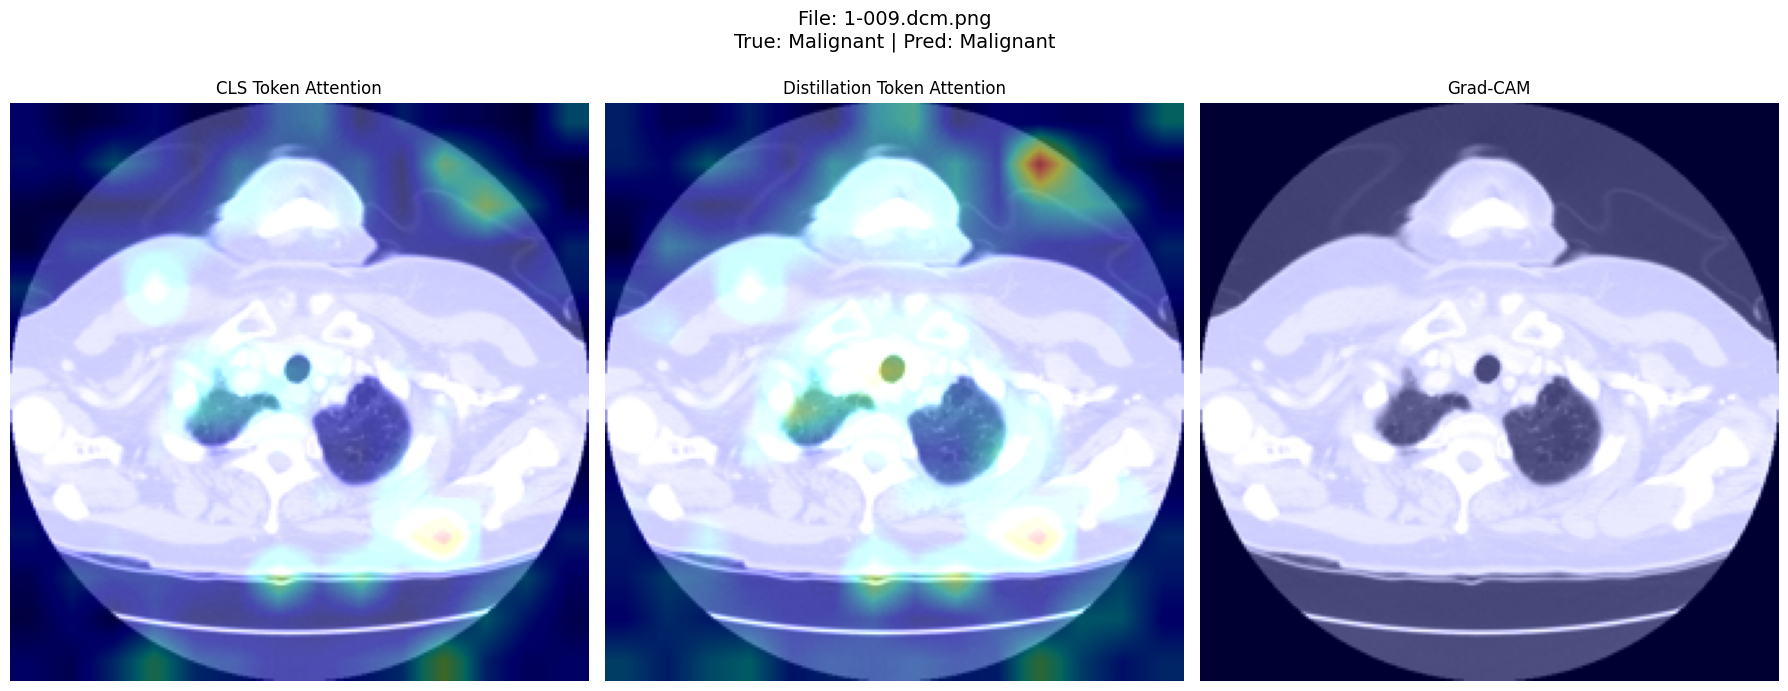

In [13]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from transformers import DeiTForImageClassificationWithTeacher, DeiTImageProcessor

def show_cam_on_image(img_np, cam_np):
    heatmap = plt.cm.jet(cam_np)[..., :3]
    superimposed_img = heatmap * 0.4 + img_np
    superimposed_img = np.clip(superimposed_img, 0, 1)
    return superimposed_img

class TransformerGradCAM:
    def __init__(self, model, target_block, num_special_tokens=2):
        self.model = model
        self.target_block = target_block
        self.num_special_tokens = num_special_tokens
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _capture_activations(self, module, inp, out):
        self.activations = out[0]

    def _capture_gradients(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def _register_hooks(self):
        self.h_activations = self.target_block.register_forward_hook(self._capture_activations)
        self.h_gradients = self.target_block.register_full_backward_hook(self._capture_gradients)

    def remove_hooks(self):
        self.h_activations.remove()
        self.h_gradients.remove()

    @torch.no_grad()
    def _predict(self, input_tensor):
        return self.model(**input_tensor)

    def __call__(self, input_tensor, target_class):
        for k in input_tensor:
            input_tensor[k].requires_grad_(True)
        self.model.zero_grad()
        with torch.enable_grad():
            output = self.model(**input_tensor)
            logits = output.logits
            loss = logits[:, target_class].sum()
        self.model.zero_grad()
        loss.backward(retain_graph=True)

        activations = self.activations[:, self.num_special_tokens:, :]
        gradients = self.gradients[:, self.num_special_tokens:, :]

        alpha = gradients.mean(dim=-1, keepdim=True)
        cam = F.relu((alpha * activations).sum(dim=-1)).view(-1, 14, 14)

        cam = F.interpolate(cam.unsqueeze(1), (224, 224), mode='bilinear', align_corners=False).squeeze(1)
        cam = cam[0].detach().cpu().numpy()
        vmax, vmin = cam.max(), cam.min()
        if vmax == vmin:
            return np.zeros_like(cam)
        cam = (cam - vmin) / (vmax - vmin)
        return cam

def generate_and_plot_heatmaps(model, processor, class_mapping, image_path, target_class_name, target_class_index, device):
    pil_img = Image.open(image_path).convert('RGB')
    display_img_np = np.array(pil_img.resize((224, 224))) / 255.0
    inputs = processor(images=pil_img, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    predicted_class_index = outputs.logits.argmax(-1).item()
    predicted_class_name = class_mapping[predicted_class_index]

    att_mat = outputs.attentions[-1]
    att_mat = torch.mean(att_mat, dim=1)

    # CLS token attention
    cls_to_patch_att = att_mat[0, 0, 2:].reshape(1, 1, 14, 14)  # shape (1,1,14,14)
    cls_att_resized = F.interpolate(cls_to_patch_att, size=(224, 224), mode='bilinear', align_corners=False)
    cls_att_resized = cls_att_resized.squeeze().detach().cpu().numpy()
    cls_att_normalized = (cls_att_resized - cls_att_resized.min()) / (cls_att_resized.max() - cls_att_resized.min())
    vis_cls_attention = show_cam_on_image(display_img_np, cls_att_normalized)
    
    # Distillation token attention
    distil_to_patch_att = att_mat[0, 1, 2:].reshape(1, 1, 14, 14)
    distil_att_resized = F.interpolate(distil_to_patch_att, size=(224, 224), mode='bilinear', align_corners=False)
    distil_att_resized = distil_att_resized.squeeze().detach().cpu().numpy()
    distil_att_normalized = (distil_att_resized - distil_att_resized.min()) / (distil_att_resized.max() - distil_att_resized.min())
    vis_distil_attention = show_cam_on_image(display_img_np, distil_att_normalized)


    grad_cam_generator = TransformerGradCAM(model, model.deit.encoder.layer[-1], num_special_tokens=2)
    grad_cam_heatmap = grad_cam_generator(inputs, target_class=target_class_index)
    grad_cam_generator.remove_hooks()
    vis_grad_cam = show_cam_on_image(display_img_np, grad_cam_heatmap)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 7))
    fig.suptitle(f"File: {os.path.basename(image_path)}\nTrue: {target_class_name} | Pred: {predicted_class_name}", fontsize=14)
    ax1.imshow(vis_cls_attention); ax1.set_title("CLS Token Attention"); ax1.axis('off')
    ax2.imshow(vis_distil_attention); ax2.set_title("Distillation Token Attention"); ax2.axis('off')
    ax3.imshow(vis_grad_cam); ax3.set_title("Grad-CAM"); ax3.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    MODEL_NAME = 'facebook/deit-base-distilled-patch16-224'
    model = DeiTForImageClassificationWithTeacher.from_pretrained(
        MODEL_NAME,
        num_labels=2,
        ignore_mismatched_sizes=True,
        attn_implementation="eager"
    ).to(device)

    model_path = "/kaggle/input/lidc-idri-9565model/best_model_reduce_lr.pth"
    state_dict = torch.load(model_path, map_location="cpu")

    for key in list(state_dict.keys()):
        if "classifier" in key:
            del state_dict[key]

    missing, unexpected = model.load_state_dict(state_dict, strict=False)
    print("Missing keys:", missing)
    print("Unexpected keys:", unexpected)
    print("Weights loaded. Device:", device)

    model.eval()
    processor = DeiTImageProcessor.from_pretrained(MODEL_NAME)

    base_path = "/kaggle/input/lung-cancer-detection-lidc-idri-subset/LIDC_IDRI_PNG_CONV/test"
    image_folders = {
        "Benign":    {"path": os.path.join(base_path, "benign"),    "class_index": 0},
        "Malignant": {"path": os.path.join(base_path, "malignant"), "class_index": 1}
    }
    class_mapping = {v['class_index']: k for k, v in image_folders.items()}
    IMAGES_PER_CATEGORY = 3

    for class_name, info in image_folders.items():
        folder_path = info["path"]
        class_index = info["class_index"]
        print("-" * 50)
        print(f"Processing Category: {class_name}")
        print("-" * 50)

        if not os.path.isdir(folder_path):
            print(f"  ERROR: Directory not found at {folder_path}")
            continue

        image_files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        files_to_process = image_files[:IMAGES_PER_CATEGORY]
        if not files_to_process:
            print(f"  No images found in {folder_path}")
            continue

        for filename in files_to_process:
            print(f"\nAnalyzing image: {filename}")
            image_path = os.path.join(folder_path, filename)
            try:
                generate_and_plot_heatmaps(model, processor, class_mapping, image_path, class_name, class_index, device)
            except Exception as e:
                print(f"  Failed on {filename}: {e}")

